# Intro

## RMSprop

RMS = root-mean-square (prop = propagation).

Similar concept as momentum: Bias the weight changes using dampened previous gradients.

RMSprop solution: Instead of biasing the gradient, bias the learning rate according to the magnitude of gradient.

$$ v = (1-\beta)(dJ)^2 + \beta v_{t-1} $$
$$ w \leftarrow w - \frac{\eta}{\sqrt{v+\epsilon}}dJ $$

Key point: The step size for adjusting the weights depends on the history of the gradient magnitudes.

Large gradients $\rightarrow$ smaller step
Small gradients $\rightarrow$ larger step

Lerge gradients indicate oscillations or volatile learning.

Implications: Remember that the gradient stores the partial derivatives along each direction, so RMSprop adjusts the learning rate for each direction (each weights).

RMSprop is less affected by the initial learning rate choice, and automatically implements learning rate decay (cf. vanilla SGD)

## Adam

Adam: Adaptive moment

Idea: Combine momentum and RMSprop

$$ v = (1 - \beta_1) dJ + \beta_1 v_{t-1} $$
$$ s = (1 - \beta_2)(dJ)^2 + \beta_2s_t -1 $$
$$ w\leftarrow w - \frac{\eta}{\sqrt{\widetilde{s}+\epsilon}}\widetilde{v} $$

Bias correction factor:

$\widetilde{v} = \frac{v}{1 - \beta^t_1} $
$\widetilde{s} = \frac{s}{1 - \beta^t_2} $

Recommended params:

* $\eta = .001 $
* $\beta_1 = .9 $
* $\beta_2 = .999 $
* $\epsilon = 10^{-8} (1E - 8) $

Adam is generally considered the current best.

# Optimizers comparison

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## Data

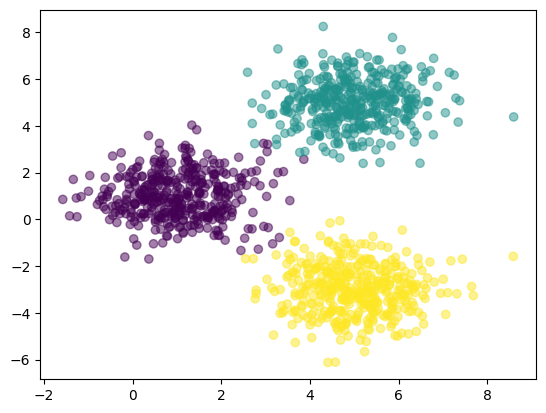

In [ ]:
n_per_clust = 400
blur = 1

A = [1,1]
B = [5,5]
C = [5,-3]

a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

labels_np = np.hstack((
    np.zeros(n_per_clust),
    np.ones(n_per_clust),
    1 + np.ones(n_per_clust)
))

data_np = np.hstack((
    a,b,c
)).T

labels = torch.tensor(labels_np, dtype = torch.long)
data = torch.tensor(data_np, dtype = torch.float)

plt.scatter(data[:,0], data[:,1], c = labels, alpha =.5)

plt.show()

## Split

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

## Model Arch

In [ ]:
class ModelArch(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(2, 16)
    self.f1 = nn.Linear(16,32)
    self.f2 = nn.Linear(32, 32)
    self.output = nn.Linear(32, 3)

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)
    x = self.f1(x)
    x = F.relu(x)
    x = self.f2(x)
    x = F.relu(x)
    x = self.output(x)

    return x

## Model Setup

In [ ]:
def ModelSetup(optimizer):
  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optimizer(ann.parameters(), lr = 1e-3)
  return ann, loss_fn, optimizer

In [50]:
ann, loss_fn, optimizer = ModelSetup(torch.optim.SGD)
temp_data = torch.randn(10, 2)
temp_y_hat = ann(temp_data)
temp_y_hat

tensor([[-0.0347, -0.0366,  0.1654],
        [-0.0372, -0.0483,  0.1807],
        [-0.0201, -0.0802,  0.1198],
        [-0.0493, -0.0452,  0.1844],
        [-0.0757, -0.0786,  0.2004],
        [-0.0081, -0.0646,  0.1603],
        [-0.0397, -0.0446,  0.1605],
        [-0.0550, -0.0686,  0.1935],
        [-0.0104, -0.0653,  0.1648],
        [-0.0229, -0.0520,  0.1472]], grad_fn=<AddmmBackward0>)

## Model Train

In [72]:
def ModelTrain(epochs, optimizer):
  ann, loss_fn, optimizer = ModelSetup(optimizer)

  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)
  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataloader))
    batch_accs = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):

      batch_y_hat = ann(X_train)

      batch_loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = batch_loss

      batch_acc = 100 * torch.mean(
          (torch.argmax(batch_y_hat, axis = 1) == y_train).float()
      )
      batch_accs[batch] = batch_acc

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    train_loss = torch.mean(batch_losses)
    train_losses[epoch] = train_loss
    train_acc = torch.mean(batch_accs)
    train_accs[epoch] = train_acc

    ann.eval()
    with torch.no_grad():
      X_test, y_test = next(iter(test_dataloader))
      test_y_hat = ann(X_test)

      test_loss = loss_fn(test_y_hat, y_test)
      test_losses[epoch] = test_loss

      test_acc = 100 * torch.mean(
          (torch.argmax(test_y_hat, axis = 1) == y_test).float()
      )
      test_accs[epoch] = test_acc

    if epoch%10 == 0:
      print(f'Train Loss: {train_loss:.2f}, Train Acc: {train_acc:.2f}, Test Loss: {test_loss:.2f}, Test Acc: {test_acc:.2f}')

  return train_losses, train_accs, test_losses, test_accs, ann

In [73]:
train_losses, train_accs, test_losses, test_accs, ann = ModelTrain(epochs = 100, optimizer = torch.optim.SGD)

Train Loss: 1.13, Train Acc: 38.44, Test Loss: 1.13, Test Acc: 36.25
Train Loss: 1.07, Train Acc: 35.42, Test Loss: 1.06, Test Acc: 35.83
Train Loss: 1.00, Train Acc: 47.60, Test Loss: 0.99, Test Acc: 47.08
Train Loss: 0.92, Train Acc: 66.25, Test Loss: 0.91, Test Acc: 66.67
Train Loss: 0.84, Train Acc: 68.44, Test Loss: 0.83, Test Acc: 66.25
Train Loss: 0.76, Train Acc: 67.92, Test Loss: 0.75, Test Acc: 67.08
Train Loss: 0.69, Train Acc: 68.33, Test Loss: 0.68, Test Acc: 67.08
Train Loss: 0.62, Train Acc: 69.58, Test Loss: 0.62, Test Acc: 67.50
Train Loss: 0.57, Train Acc: 70.83, Test Loss: 0.56, Test Acc: 67.50
Train Loss: 0.53, Train Acc: 71.46, Test Loss: 0.52, Test Acc: 68.33


## Plot

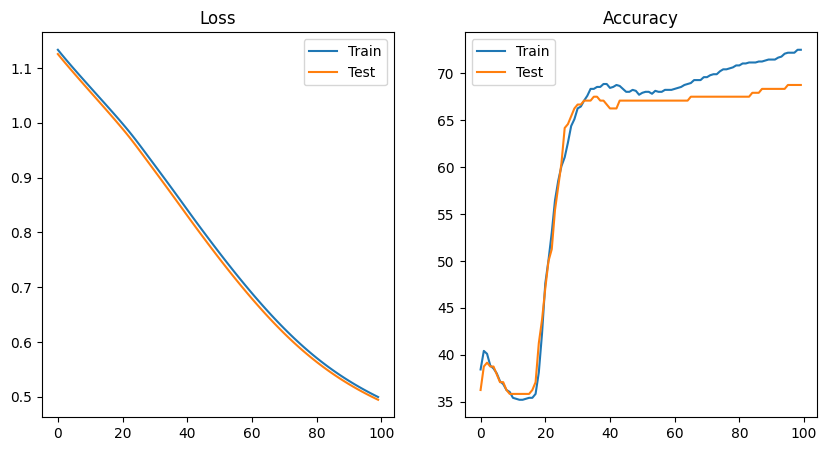

In [74]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(train_losses.detach())
ax[0].plot(test_losses.detach())
ax[0].set_title('Loss')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_accs.detach())
ax[1].plot(test_accs.detach())
ax[1].set_title('Accuracy')
ax[1].legend(['Train', 'Test'])
plt.show()

## Experiment

In [85]:
epochs = 300
optimizers = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam,
    "AdamW": torch.optim.AdamW,
    "Adamax": torch.optim.Adamax,
    "NAdam": torch.optim.NAdam,
    "RAdam": torch.optim.RAdam,
    "ASGD": torch.optim.ASGD,
    "RMSprop": torch.optim.RMSprop,
    "Rprop": torch.optim.Rprop,
}
results = torch.zeros(epochs, len(optimizers) ,4)

for optimizer_idx, optimizer_name in enumerate(optimizers):
  print(f'\n\n\nPROCESSING OPTIMIZER: {optimizer_name}')
  train_losses, train_accs, test_losses, test_accs, ann = ModelTrain(epochs = epochs, optimizer = optimizers[optimizer_name])

  results[:,optimizer_idx, 0] = train_losses
  results[:,optimizer_idx, 1] = train_accs
  results[:,optimizer_idx, 2] = test_losses
  results[:,optimizer_idx, 3] = test_accs




PROCESSING OPTIMIZER: SGD
Train Loss: 1.08, Train Acc: 40.73, Test Loss: 1.07, Test Acc: 43.33
Train Loss: 1.01, Train Acc: 70.21, Test Loss: 1.01, Test Acc: 71.67
Train Loss: 0.94, Train Acc: 69.48, Test Loss: 0.95, Test Acc: 71.67
Train Loss: 0.88, Train Acc: 69.90, Test Loss: 0.89, Test Acc: 71.25
Train Loss: 0.82, Train Acc: 70.10, Test Loss: 0.83, Test Acc: 71.67
Train Loss: 0.76, Train Acc: 71.04, Test Loss: 0.77, Test Acc: 72.50
Train Loss: 0.70, Train Acc: 71.98, Test Loss: 0.71, Test Acc: 72.92
Train Loss: 0.64, Train Acc: 72.71, Test Loss: 0.65, Test Acc: 74.58
Train Loss: 0.59, Train Acc: 74.58, Test Loss: 0.60, Test Acc: 75.00
Train Loss: 0.54, Train Acc: 76.77, Test Loss: 0.55, Test Acc: 75.83
Train Loss: 0.51, Train Acc: 79.17, Test Loss: 0.51, Test Acc: 76.67
Train Loss: 0.47, Train Acc: 82.19, Test Loss: 0.48, Test Acc: 79.17
Train Loss: 0.45, Train Acc: 83.85, Test Loss: 0.45, Test Acc: 81.25
Train Loss: 0.42, Train Acc: 85.94, Test Loss: 0.42, Test Acc: 84.17
Train

/tmp/ipython-input-1929454930.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


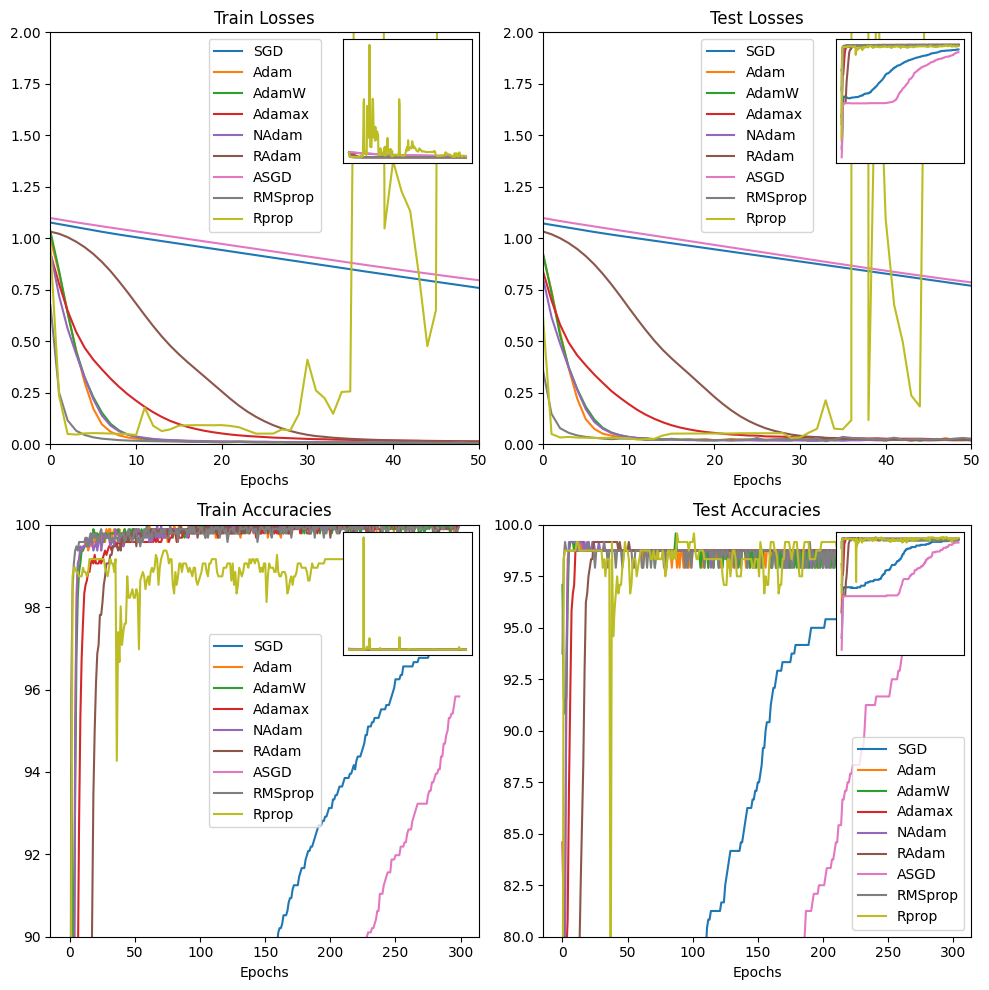

In [122]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10,10))

# główne ploty z zoomem
ax[0][0].plot(results[:,:,0].detach())
ax[0][0].set_title('Train Losses')
ax[0][0].set_ylim([0,2])
ax[0][0].set_xlim([0,50])

ax[0][1].plot(results[:,:,2].detach())
ax[0][1].set_title('Test Losses')
ax[0][1].set_ylim([0,2])
ax[0][1].set_xlim([0,50])

ax[1][0].plot(results[:,:,1].detach())
ax[1][0].set_title('Train Accuracies')
ax[1][0].set_ylim([90,100])

ax[1][1].plot(results[:,:,3].detach())
ax[1][1].set_title('Test Accuracies')
ax[1][1].set_ylim([80,100])

# insety z pełnym wykresem (bez zooma)
for i in range(2):
    for j in range(2):
        ax[i][j].legend(optimizers)
        ax[i][j].set_xlabel('Epochs')

        # inset w prawym górnym rogu
        axins = inset_axes(ax[i][j], width="30%", height="30%", loc='upper right')
        axins.plot(results[:,:,i*2+j].detach())

        # pokaz pełny zakres osi bez żadnych limitów
        axins.relim()
        axins.autoscale_view()

        # uprość inset — bez osi
        axins.set_xticks([])
        axins.set_yticks([])

plt.tight_layout()
plt.show()


As we can see Rprop, SGD, and ASGD perform poorly in comparison to the rest of the optimizers.

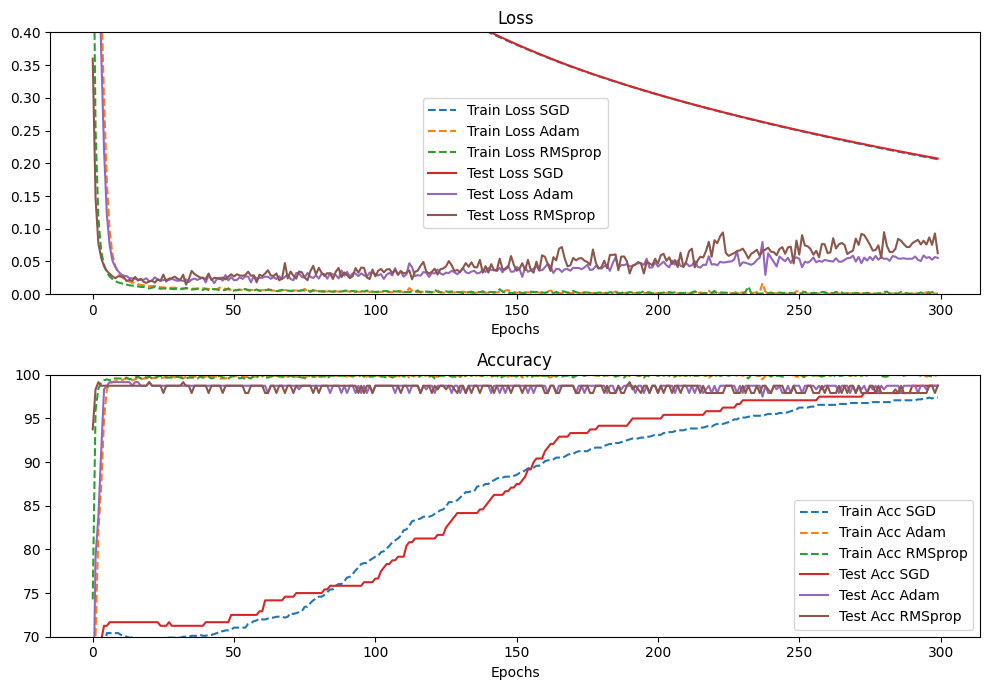

In [152]:
fig, ax = plt.subplots(2, 1, figsize = (10,7))

ax[0].plot(results[:,0,0].detach(), '--', label = 'Train Loss SGD')
ax[0].plot(results[:,1,0].detach(), '--', label = 'Train Loss Adam')
ax[0].plot(results[:,7,0].detach(), '--', label = 'Train Loss RMSprop')

ax[0].plot(results[:,0,2].detach(), label = 'Test Loss SGD')
ax[0].plot(results[:,1,2].detach(), label = 'Test Loss Adam')
ax[0].plot(results[:,7,2].detach(), label = 'Test Loss RMSprop')
ax[0].legend()
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylim([0,.4])


ax[1].plot(results[:,0,1].detach(), '--', label = 'Train Acc SGD')
ax[1].plot(results[:,1,1].detach(), '--', label = 'Train Acc Adam')
ax[1].plot(results[:,7,1].detach(), '--', label = 'Train Acc RMSprop')

ax[1].plot(results[:,0,3].detach(), label = 'Test Acc SGD')
ax[1].plot(results[:,1,3].detach(), label = 'Test Acc Adam')
ax[1].plot(results[:,7,3].detach(), label = 'Test Acc RMSprop')
ax[1].legend()
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylim([70,100])

# for i in range(2):
#   ax[i][j].set_xlim([0,20])

plt.tight_layout()
plt.show()